In [ ]:
!pip install nltk

In [ ]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
import pickle
import warnings
warnings.filterwarnings('ignore')

# Download resource NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
def preprocess_text(text):
    """Preprocessing teks untuk ekstraksi fitur"""
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    if pd.isna(text):
        return ""

    text = str(text).lower()
    # Hapus tanda baca kecuali koma
    text = re.sub(r'[^\w\s,]', '', text)

    # Pisahkan berdasarkan koma untuk daftar bahan
    ingredients = [ingredient.strip() for ingredient in text.split(',')]

    # Tokenisasi dan lemmatization
    tokens = []
    for ingredient in ingredients:
        words = word_tokenize(ingredient)
        words = [lemmatizer.lemmatize(word) for word in words
                if word not in stop_words and len(word) > 2]
        tokens.extend(words)

    return ' '.join(tokens)

In [ ]:
def preprocess_dataframe(df):
    """Preprocessing complete dataframe"""
    print("🔄 Memulai preprocessing data...")

    # Bersihkan data
    df = df.drop_duplicates(subset=['id', 'nama'], keep='first')
    df['deskripsi'] = df['deskripsi'].fillna('')

    # Preprocessing teks
    df['deskripsi_Clean'] = df['deskripsi'].apply(preprocess_text)

    # Encode categorical variables
    le_category = LabelEncoder()
    df['category_Encoded'] = le_category.fit_transform(df['category'])

    # Tambahkan feature engineering
    df['Ingredient_Count'] = df['deskripsi'].apply(lambda x: len(x.split(',')))
    df['Text_Length'] = df['deskripsi_Clean'].apply(len)

    print(f"✅ Preprocessing selesai! Dataset shape: {df.shape}")
    return df, le_category

In [ ]:
def extract_tfidf_features(df, max_features=1000):
    """Ekstraksi fitur menggunakan TF-IDF"""
    print("🔄 Ekstraksi fitur TF-IDF...")

    # TF-IDF dari teks yang telah dibersihkan
    tfidf_vectorizer = TfidfVectorizer(
        max_features=max_features,
        stop_words='english',
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95
    )

    tfidf_matrix = tfidf_vectorizer.fit_transform(df['deskripsi_Clean']).toarray()

    # Fitur tambahan dengan normalisasi
    additional_features = df[['category_Encoded', 'Ingredient_Count', 'Text_Length']].values

    # Normalisasi fitur tambahan
    scaler = StandardScaler()
    additional_features_scaled = scaler.fit_transform(additional_features)

    # Gabungkan semua fitur
    feature_matrix = np.hstack([
        tfidf_matrix,
        additional_features_scaled * 0.3  # Weight untuk fitur tambahan
    ])

    feature_names = (list(tfidf_vectorizer.get_feature_names_out()) +
                    ['category', 'Ingredient_Count', 'Text_Length'])

    print(f"✅ Feature extraction selesai! Feature shape: {feature_matrix.shape}")
    return feature_matrix, tfidf_vectorizer, scaler, feature_names

In [ ]:
def build_autoencoder_model(input_dim):
    """Build autoencoder model untuk learning representations"""
    print("🔄 Building TensorFlow autoencoder model...")

    # Input layer
    input_layer = Input(shape=(input_dim,), name='input_layer')

    # Encoder
    encoded = Dense(512, activation='relu', name='encoder_1')(input_layer)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.3)(encoded)

    encoded = Dense(256, activation='relu', name='encoder_2')(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.3)(encoded)

    # Bottleneck layer (embedding)
    embedding = Dense(128, activation='relu', name='embedding')(encoded)

    # Decoder
    decoded = Dense(256, activation='relu', name='decoder_1')(embedding)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(0.3)(decoded)

    decoded = Dense(512, activation='relu', name='decoder_2')(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(0.3)(decoded)

    # Output layer
    output_layer = Dense(input_dim, activation='sigmoid', name='output_layer')(decoded)

    # Autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=output_layer, name='food_autoencoder')

    # Embedding extractor model
    embedding_model = Model(inputs=input_layer, outputs=embedding, name='food_embedding')

    # Compile model
    autoencoder.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    print("✅ Model berhasil dibuild!")
    return autoencoder, embedding_model

In [ ]:
def train_autoencoder_model(model, X_train, X_val, epochs=100, batch_size=32):
    """Training model dengan callbacks"""
    print("🔄 Memulai training model...")

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint('best_food_model.h5', save_best_only=True, monitor='val_loss'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
    ]

    # Training
    history = model.fit(
        X_train, X_train,
        validation_data=(X_val, X_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    print("✅ Training selesai!")
    return history

In [ ]:
def compute_similarity_matrix(embedding_model, feature_matrix):
    """Hitung cosine similarity matrix menggunakan embeddings"""
    print("🔄 Menghitung cosine similarity matrix...")

    # Dapatkan embeddings dari model
    embeddings = embedding_model.predict(feature_matrix)

    # Hitung cosine similarity
    cosine_sim_matrix = cosine_similarity(embeddings)

    print("✅ Cosine similarity matrix berhasil dihitung!")
    return cosine_sim_matrix, embeddings

In [ ]:
def get_recommendations(food_id, df, cosine_sim_matrix, top_n=10):
    """Dapatkan rekomendasi untuk id tertentu"""
    try:
        # Cari index dari id
        idx = df[df['id'] == food_id].index
        if len(idx) == 0:
            return f"❌ id {food_id} tidak ditemukan."

        idx = idx[0]

        # Dapatkan similarity scores
        sim_scores = list(enumerate(cosine_sim_matrix[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:top_n+1]  # Exclude self

        # Buat DataFrame hasil rekomendasi
        food_indices = [i[0] for i in sim_scores]
        similarities = [i[1] for i in sim_scores]

        result_df = df.iloc[food_indices][
            ['id', 'nama', 'category', 'deskripsi']
        ].copy()
        result_df['Similarity_Score'] = similarities

        return result_df

    except Exception as e:
        return f"❌ Error: {str(e)}"

In [ ]:
def evaluate_recommendations(df, cosine_sim_matrix, test_size=100):
    """Evaluasi model dengan precision"""
    print("🔄 Evaluasi model...")

    # Sample test food IDs
    test_food_ids = df['id'].sample(min(test_size, len(df)), random_state=42)

    precisions = []

    for food_id in test_food_ids:
        recommendations = get_recommendations(food_id, df, cosine_sim_matrix, top_n=10)

        if isinstance(recommendations, pd.DataFrame):
            target_category = df[df['id'] == food_id]['category'].values[0]

            # Precision: berapa banyak rekomendasi yang sama kategorinya
            relevant_category = sum(1 for _, row in recommendations.iterrows()
                                  if row['category'] == target_category)
            precision = relevant_category / len(recommendations)

            precisions.append(precision)

    avg_precision = np.mean(precisions)

    print(f"✅ Average Precision@10: {avg_precision:.4f}")

    return avg_precision

In [ ]:
def plot_training_history(history):
    """Plot training history"""
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
def plot_word_cloud(df):
    """Buat word cloud dari ingredients"""
    all_text = ' '.join(df['deskripsi_Clean'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud dari Bahan')
    plt.savefig('wordcloud_ingredients.png')
    plt.show()

In [ ]:
def plot_data_distribution(df):
    """Plot distribusi data"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Distribusi category
    sns.countplot(x='category', data=df, ax=axes[0,0])
    axes[0,0].set_title('Distribusi Kategori')
    axes[0,0].tick_params(axis='x', rotation=45)

    # Distribusi harga
    sns.histplot(df['harga'], bins=20, ax=axes[0,1])
    axes[0,1].set_title('Distribusi Harga')

    # Distribusi jumlah ingredient
    sns.histplot(df['Ingredient_Count'], bins=20, ax=axes[1,0])
    axes[1,0].set_title('Distribusi Jumlah Bahan')

    # Distribusi panjang teks
    sns.histplot(df['Text_Length'], bins=20, ax=axes[1,1])
    axes[1,1].set_title('Distribusi Panjang Teks')

    plt.tight_layout()
    plt.savefig('data_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
def save_all_components(autoencoder, embedding_model, tfidf_vectorizer, scaler, cosine_sim_matrix):
    """Simpan semua komponen model"""
    print("🔄 Menyimpan semua komponen...")

    # Simpan models
    autoencoder.save('food_recommendation_model.h5')
    embedding_model.save('food_embedding_model.h5')

    # Simpan vectorizer dan scaler
    with open('tfidf_vectorizer.pkl', 'wb') as f:
        pickle.dump(tfidf_vectorizer, f)

    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)

    # Simpan similarity matrix
    np.save('cosine_similarity_matrix.npy', cosine_sim_matrix)

    print("✅ Semua komponen berhasil disimpan!")

In [ ]:
def load_all_components():
    """Load semua komponen model"""
    print("🔄 Loading semua komponen...")

    # Load models
    autoencoder = load_model('food_recommendation_model.h5')
    embedding_model = load_model('food_embedding_model.h5')

    # Load vectorizer dan scaler
    with open('tfidf_vectorizer.pkl', 'rb') as f:
        tfidf_vectorizer = pickle.load(f)

    with open('scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)

    # Load similarity matrix
    cosine_sim_matrix = np.load('cosine_similarity_matrix.npy')

    print("✅ Semua komponen berhasil di-load!")
    return autoencoder, embedding_model, tfidf_vectorizer, scaler, cosine_sim_matrix

In [ ]:
def inference_with_saved_model(food_id, top_n=5):
    """
    Fungsi inference menggunakan model yang sudah disimpan
    """
    print(f"🔄 Loading saved model untuk inference id: {food_id}")

    try:
        # Load semua komponen
        autoencoder, embedding_model, tfidf_vectorizer, scaler, cosine_sim_matrix = load_all_components()

        # Load dan preprocessing data
        df = pd.read_csv('food_dataset.csv')
        df_processed, _ = preprocess_dataframe(df)

        # Dapatkan rekomendasi
        recommendations = get_recommendations(food_id, df_processed, cosine_sim_matrix, top_n=top_n)

        print("✅ Inference berhasil!")
        return recommendations

    except Exception as e:
        return f"❌ Error dalam inference: {str(e)}"

In [ ]:
# 1. Load dataset
print("\n📊 Step 1: Loading Dataset")
df = pd.read_csv('food_dataset.csv')
print(f"📁 Dataset loaded: {df.shape}")
print(f"🔍 Columns: {list(df.columns)}")


📊 Step 1: Loading Dataset
📁 Dataset loaded: (400, 8)
🔍 Columns: ['id', 'nama', 'harga', 'stock', 'category', 'image', 'deskripsi', 'create_at']


In [ ]:
# 2. Data preprocessing
print("\n🔧 Step 2: Data Preprocessing")
df_processed, le_category = preprocess_dataframe(df)


🔧 Step 2: Data Preprocessing
🔄 Memulai preprocessing data...
✅ Preprocessing selesai! Dataset shape: (400, 12)



📈 Step 3: Exploratory Data Analysis


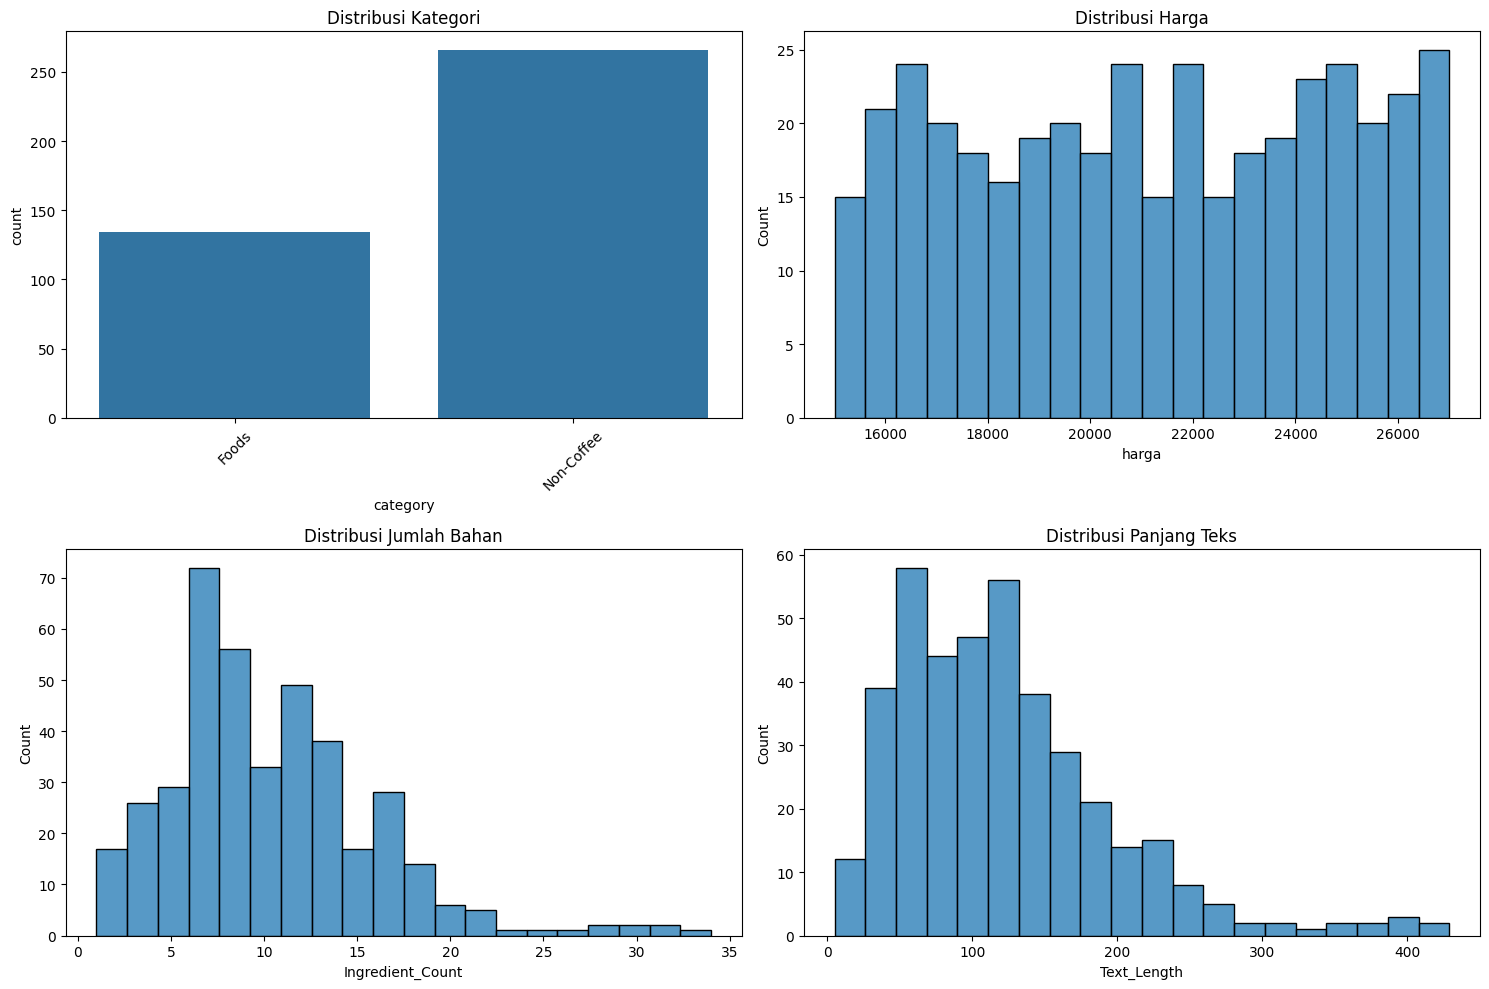

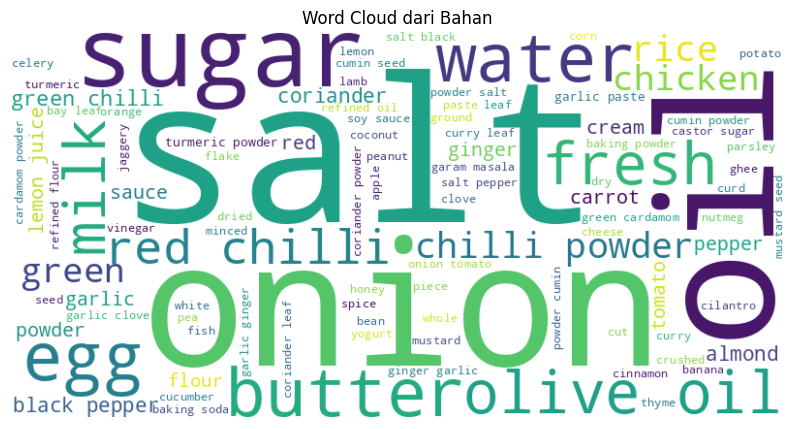

In [ ]:
# 3. Exploratory Data Analysis
print("\n📈 Step 3: Exploratory Data Analysis")
plot_data_distribution(df_processed)
plot_word_cloud(df_processed)

In [ ]:
# 4. Feature extraction
print("\n🎯 Step 4: Feature Extraction")
feature_matrix, tfidf_vectorizer, scaler, feature_names = extract_tfidf_features(df_processed, max_features=1000)


🎯 Step 4: Feature Extraction
🔄 Ekstraksi fitur TF-IDF...
✅ Feature extraction selesai! Feature shape: (400, 1003)


In [ ]:
# 5. Split data untuk training
print("\n✂️  Step 5: Data Splitting")
X_train, X_val = train_test_split(feature_matrix, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")


✂️  Step 5: Data Splitting
Training set: (320, 1003)
Validation set: (80, 1003)


In [ ]:
# 6. Build model
print("\n🏗️  Step 6: Building Model")
autoencoder, embedding_model = build_autoencoder_model(input_dim=feature_matrix.shape[1])


🏗️  Step 6: Building Model
🔄 Building TensorFlow autoencoder model...
✅ Model berhasil dibuild!


In [ ]:
# Print model summary
print("\n📋 Model Summary:")
autoencoder.summary()


📋 Model Summary:


Model: "food_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1003)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 512)            │       514,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_2 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Dense)               │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1003)           │       514,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,363,563 (5.20 MB)

 Trainable params: 1,360,491 (5.19 MB)

 Non-trainable params: 3,072 (12.00 KB)

In [ ]:
# 7. Training model
print("\n🚀 Step 7: Training Model")
history = train_autoencoder_model(autoencoder, X_train, X_val, epochs=50, batch_size=32)


🚀 Step 7: Training Model
🔄 Memulai training model...
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2872 - mae: 0.4953

10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - loss: 0.2871 - mae: 0.4952 - val_loss: 0.2408 - val_mae: 0.4896 - learning_rate: 0.0010
Epoch 2/50
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2796 - mae: 0.4913

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.2791 - mae: 0.4910 - val_loss: 0.2298 - val_mae: 0.4781 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2674 - mae: 0.4825

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.2672 - mae: 0.4823 - val_loss: 0.2126 - val_mae: 0.4597 - learning_rate: 0.0010
Epoch 4/50
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2515 - mae: 0.4687

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.2506 - mae: 0.4679 - val_loss: 0.1907 - val_mae: 0.4352 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2357 - mae: 0.4545

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2352 - mae: 0.4539 - val_loss: 0.1672 - val_mae: 0.4073 - learning_rate: 0.0010
Epoch 6/50
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2098 - mae: 0.4284

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.2083 - mae: 0.4267 - val_loss: 0.1438 - val_mae: 0.3774 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1800 - mae: 0.3966

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1792 - mae: 0.3956 - val_loss: 0.1161 - val_mae: 0.3388 - learning_rate: 0.0010
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1401 - mae: 0.3468

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1392 - mae: 0.3455 - val_loss: 0.0845 - val_mae: 0.2887 - learning_rate: 0.0010
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1039 - mae: 0.2945

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1032 - mae: 0.2933 - val_loss: 0.0534 - val_mae: 0.2290 - learning_rate: 0.0010
Epoch 10/50
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0703 - mae: 0.2370

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0693 - mae: 0.2350 - val_loss: 0.0376 - val_mae: 0.1918 - learning_rate: 0.0010
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0463 - mae: 0.1876

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0459 - mae: 0.1868 - val_loss: 0.0200 - val_mae: 0.1394 - learning_rate: 0.0010
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0280 - mae: 0.1445

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0280 - mae: 0.1443 - val_loss: 0.0160 - val_mae: 0.1247 - learning_rate: 0.0010
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0203 - mae: 0.1246

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0202 - mae: 0.1242 - val_loss: 0.0081 - val_mae: 0.0876 - learning_rate: 0.0010
Epoch 14/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0162 - mae: 0.1044

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0160 - mae: 0.1039 - val_loss: 0.0064 - val_mae: 0.0769 - learning_rate: 0.0010
Epoch 15/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0112 - mae: 0.0894

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0112 - mae: 0.0892 - val_loss: 0.0061 - val_mae: 0.0754 - learning_rate: 0.0010
Epoch 16/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0102 - mae: 0.0807

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0101 - mae: 0.0803 - val_loss: 0.0047 - val_mae: 0.0650 - learning_rate: 0.0010
Epoch 17/50
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0075 - mae: 0.0715

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0074 - mae: 0.0711 - val_loss: 0.0042 - val_mae: 0.0602 - learning_rate: 0.0010
Epoch 18/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0059 - mae: 0.0620 - val_loss: 0.0043 - val_mae: 0.0611 - learning_rate: 0.0010
Epoch 19/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0060 - mae: 0.0629

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0060 - mae: 0.0627 - val_loss: 0.0035 - val_mae: 0.0545 - learning_rate: 0.0010
Epoch 20/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0053 - mae: 0.0571

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0052 - mae: 0.0569 - val_loss: 0.0028 - val_mae: 0.0464 - learning_rate: 0.0010
Epoch 21/50
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0042 - mae: 0.0514

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0042 - mae: 0.0510 - val_loss: 0.0024 - val_mae: 0.0416 - learning_rate: 0.0010
Epoch 22/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0048 - mae: 0.0503 - val_loss: 0.0026 - val_mae: 0.0445 - learning_rate: 0.0010
Epoch 23/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0035 - mae: 0.0456 - val_loss: 0.0024 - val_mae: 0.0418 - learning_rate: 0.0010
Epoch 24/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0032 - mae: 0.0428

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0032 - mae: 0.0427 - val_loss: 0.0022 - val_mae: 0.0390 - learning_rate: 0.0010
Epoch 25/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0033 - mae: 0.0410

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0033 - mae: 0.0409 - val_loss: 0.0022 - val_mae: 0.0381 - learning_rate: 0.0010
Epoch 26/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0025 - mae: 0.0369

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0025 - mae: 0.0369 - val_loss: 0.0021 - val_mae: 0.0369 - learning_rate: 0.0010
Epoch 27/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0026 - mae: 0.0380

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0026 - mae: 0.0379 - val_loss: 0.0020 - val_mae: 0.0349 - learning_rate: 0.0010
Epoch 28/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0023 - mae: 0.0342

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0023 - mae: 0.0342 - val_loss: 0.0019 - val_mae: 0.0329 - learning_rate: 0.0010
Epoch 29/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0024 - mae: 0.0344 - val_loss: 0.0019 - val_mae: 0.0335 - learning_rate: 0.0010
Epoch 30/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0023 - mae: 0.0334 - val_loss: 0.0019 - val_mae: 0.0333 - learning_rate: 0.0010
Epoch 31/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0034 - mae: 0.0358 - val_loss: 0.0023 - val_mae: 0.0398 - learning_rate: 0.0010
Epoch 32/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0027 - mae: 0.0376 - val_loss: 0.0020 - val_mae: 0.0359 - learning_rate: 0.0010
Epoch 33/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0024 - mae: 0.0353

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0024 - mae: 0.0353 - val_loss: 0.0017 - val_mae: 0.0300 - learning_rate: 0.0010
Epoch 34/50
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0020 - mae: 0.0307

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0020 - mae: 0.0307 - val_loss: 0.0015 - val_mae: 0.0263 - learning_rate: 0.0010
Epoch 35/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0019 - mae: 0.0301

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0019 - mae: 0.0301 - val_loss: 0.0015 - val_mae: 0.0243 - learning_rate: 0.0010
Epoch 36/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0019 - mae: 0.0284

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0019 - mae: 0.0284 - val_loss: 0.0014 - val_mae: 0.0239 - learning_rate: 0.0010
Epoch 37/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0017 - mae: 0.0263

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0017 - mae: 0.0264 - val_loss: 0.0014 - val_mae: 0.0239 - learning_rate: 0.0010
Epoch 38/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0018 - mae: 0.0264 - val_loss: 0.0015 - val_mae: 0.0245 - learning_rate: 0.0010
Epoch 39/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0017 - mae: 0.0273 - val_loss: 0.0015 - val_mae: 0.0251 - learning_rate: 0.0010
Epoch 40/50
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0016 - mae: 0.0254

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0016 - mae: 0.0255 - val_loss: 0.0014 - val_mae: 0.0240 - learning_rate: 0.0010
Epoch 41/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0017 - mae: 0.0261

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0017 - mae: 0.0260 - val_loss: 0.0014 - val_mae: 0.0226 - learning_rate: 0.0010
Epoch 42/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0016 - mae: 0.0252

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0016 - mae: 0.0252 - val_loss: 0.0013 - val_mae: 0.0211 - learning_rate: 0.0010
Epoch 43/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0016 - mae: 0.0238

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0016 - mae: 0.0238 - val_loss: 0.0013 - val_mae: 0.0206 - learning_rate: 5.0000e-04
Epoch 44/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0017 - mae: 0.0234 - val_loss: 0.0013 - val_mae: 0.0213 - learning_rate: 5.0000e-04
Epoch 45/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0017 - mae: 0.0247 - val_loss: 0.0014 - val_mae: 0.0219 - learning_rate: 5.0000e-04
Epoch 46/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0016 - mae: 0.0243 - val_loss: 0.0013 - val_mae: 0.0215 - learning_rate: 5.0000e-04
Epoch 47/50
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0015 - mae: 0.0231

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0015 - mae: 0.0231 - val_loss: 0.0013 - val_mae: 0.0207 - learning_rate: 5.0000e-04
Epoch 48/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0015 - mae: 0.0230

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0015 - mae: 0.0230 - val_loss: 0.0013 - val_mae: 0.0205 - learning_rate: 5.0000e-04
Epoch 49/50
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0015 - mae: 0.0237

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0016 - mae: 0.0238 - val_loss: 0.0013 - val_mae: 0.0201 - learning_rate: 2.5000e-04
Epoch 50/50
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0018 - mae: 0.0240

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0017 - mae: 0.0238 - val_loss: 0.0013 - val_mae: 0.0202 - learning_rate: 2.5000e-04
✅ Training selesai!



📊 Step 8: Training Visualization


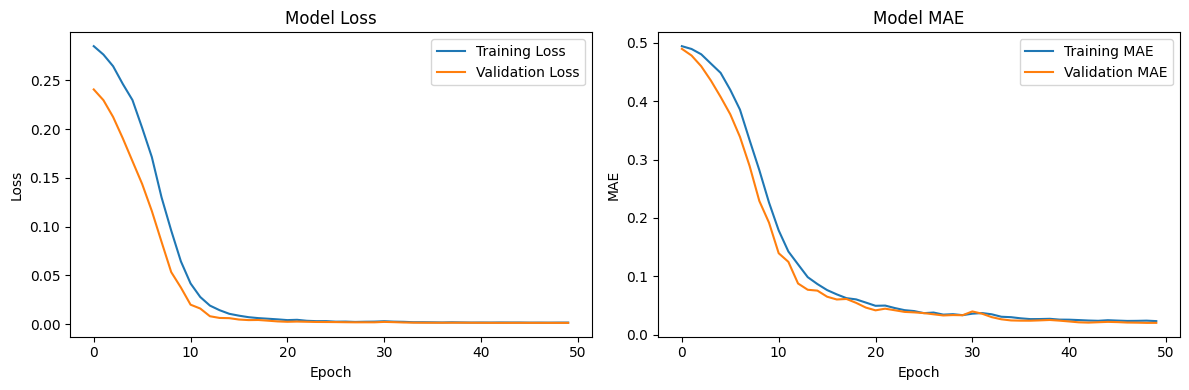

In [ ]:
# 8. Plot training history
print("\n📊 Step 8: Training Visualization")
plot_training_history(history)

In [ ]:
# 9. Compute similarity matrix
print("\n🧮 Step 9: Computing Similarity Matrix")
cosine_sim_matrix, embeddings = compute_similarity_matrix(embedding_model, feature_matrix)


🧮 Step 9: Computing Similarity Matrix
🔄 Menghitung cosine similarity matrix...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
✅ Cosine similarity matrix berhasil dihitung!


In [ ]:
# 10. Evaluasi model
print("\n📏 Step 10: Model Evaluation")
precision = evaluate_recommendations(df_processed, cosine_sim_matrix, test_size=100)


📏 Step 10: Model Evaluation
🔄 Evaluasi model...
✅ Average Precision@10: 0.8800


In [ ]:
# 11. Save all components
print("\n💾 Step 11: Saving All Components")
save_all_components(autoencoder, embedding_model, tfidf_vectorizer, scaler, cosine_sim_matrix)


💾 Step 11: Saving All Components
🔄 Menyimpan semua komponen...
✅ Semua komponen berhasil disimpan!


In [ ]:
# 12. Test recommendations
print("\n" + "=" * 60)
print("🔍 TESTING RECOMMENDATIONS")
print("=" * 60)

test_food_id = 2
recommendations = get_recommendations(test_food_id, df_processed, cosine_sim_matrix, top_n=5)

if isinstance(recommendations, pd.DataFrame):
    target_food = df_processed[df_processed['id'] == test_food_id]['nama'].values[0]
    print(f"\n🍽️ Top 5 rekomendasi untuk id {test_food_id}: {target_food}")
    print("-" * 80)

    for idx, row in recommendations.iterrows():
        print(f"📋 {row['nama']}")
        print(f"   Kategori: {row['category']}")
        print(f"   Similarity: {row['Similarity_Score']:.4f}")
        print(f"   Deskripsi: {row['deskripsi'][:100]}...")
        print()
else:
    print(recommendations)


🔍 TESTING RECOMMENDATIONS

🍽️ Top 5 rekomendasi untuk id 2: chicken minced salad
--------------------------------------------------------------------------------
📋 spaghetti with clams & crispy bread crumbs
   Kategori: Non-Coffee
   Similarity: 0.7088
   Deskripsi: panko, 1/4 cup plus 1 tablespoon extra-virgin olive oil, plus more for drizzling, kosher salt, fresh...

📋 cajun spiced turkey wrapped with bacon
   Kategori: Non-Coffee
   Similarity: 0.7038
   Deskripsi: turkey breast, cajun spice, spinach leaves (cooked and drained), garlic pods, salted butter, feta ch...

📋 corn and raw mango salad
   Kategori: Foods
   Similarity: 0.6960
   Deskripsi: Corn kernels, onions, green onions, paprika, raw mango (pieces), celery stock (pieces), cherry tomat...

📋 shrimp & cilantro ceviche
   Kategori: Non-Coffee
   Similarity: 0.6933
   Deskripsi: prawns, gherkin, onion, cilantro, mix bell pepper, tiger milk, sweet corn, sea salt, black pepper, g...

📋 beetroot and green apple soup
   Katego

In [ ]:
# 13. Test inference dengan saved model
print("\n" + "=" * 60)
print("🧪 TESTING INFERENCE WITH SAVED MODEL")
print("=" * 60)

test_result = inference_with_saved_model(food_id=5, top_n=3)

if isinstance(test_result, pd.DataFrame):
    print("🎯 Hasil inference menggunakan saved model:")
    print(test_result[['id', 'nama', 'category', 'Similarity_Score']])
else:
    print(test_result)

print("\n" + "=" * 60)
print("✅ SISTEM REKOMENDASI MAKANAN SELESAI!")
print("=" * 60)
print("📁 File yang tersimpan:")
print("   - food_recommendation_model.h5 (Autoencoder model)")
print("   - food_embedding_model.h5 (Embedding model)")
print("   - tfidf_vectorizer.pkl (TF-IDF vectorizer)")
print("   - scaler.pkl (Feature scaler)")
print("   - cosine_similarity_matrix.npy (Similarity matrix)")
print("   - training_history.png (Training visualization)")
print("   - data_distribution.png (Data analysis)")
print("   - wordcloud_ingredients.png (Word cloud)")


🧪 TESTING INFERENCE WITH SAVED MODEL
🔄 Loading saved model untuk inference id: 5
🔄 Loading semua komponen...
❌ Error dalam inference: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}

✅ SISTEM REKOMENDASI MAKANAN SELESAI!
📁 File yang tersimpan:
   - food_recommendation_model.h5 (Autoencoder model)
   - food_embedding_model.h5 (Embedding model)
   - tfidf_vectorizer.pkl (TF-IDF vectorizer)
   - scaler.pkl (Feature scaler)
   - cosine_similarity_matrix.npy (Similarity matrix)
   - training_history.png (Training visualization)
   - data_distribution.png (Data analysis)
   - wordcloud_ingredients.png (Word cloud)


In [ ]:
def test_multiple_recommendations():
    """Test rekomendasi untuk beberapa id"""
    print("\n🧪 Testing multiple recommendations...")

    test_ids = [1, 5, 10, 15, 20]

    for food_id in test_ids:
        if food_id in df_processed['id'].values:
            recs = get_recommendations(food_id, df_processed, cosine_sim_matrix, top_n=3)
            if isinstance(recs, pd.DataFrame):
                target_name = df_processed[df_processed['id'] == food_id]['nama'].values[0]
                print(f"\nID {food_id} ({target_name}):")
                for _, row in recs.iterrows():
                    print(f"  → {row['nama']} (Score: {row['Similarity_Score']:.3f})")

# Jalankan test tambahan
test_multiple_recommendations()

print("\n🎉 Semua testing selesai! Sistem siap untuk production!")


🧪 Testing multiple recommendations...

ID 1 (summer squash salad):
  → green cucumber shots (Score: 0.852)
  → mixed beans salad (Score: 0.828)
  → garlic and pinenut soup with burnt butter essence (Score: 0.805)

ID 5 (christmas cake):
  → chocolate chip cheesecake (Score: 0.785)
  → spiced orange valencia cake (Score: 0.731)
  → wok tossed asparagus in mild garlic sauce (Score: 0.724)

ID 10 (broccoli and almond soup):
  → apple kheer (Score: 0.786)
  → green lentil dessert fudge (Score: 0.759)
  → almond and amaranth ladoo (Score: 0.748)

ID 15 (almond and cranberry poha):
  → chicken tikka masala (Score: 0.826)
  → malabari fish curry (Score: 0.801)
  → sunga pork (Score: 0.750)

ID 20 (baked multigrain murukku):
  → ragi oats ladoo (laddu) (Score: 0.715)
  → baked raw banana samosa (Score: 0.688)
  → camel milk cake tart (Score: 0.680)

🎉 Semua testing selesai! Sistem siap untuk production!
